In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_algorithms

In [ ]:
!pip install qiskit_machine_learning

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

In [ ]:
!pip install pylatexenc

In [ ]:
!pip install qiskit-metal

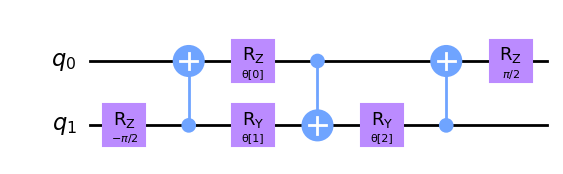

In [ ]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

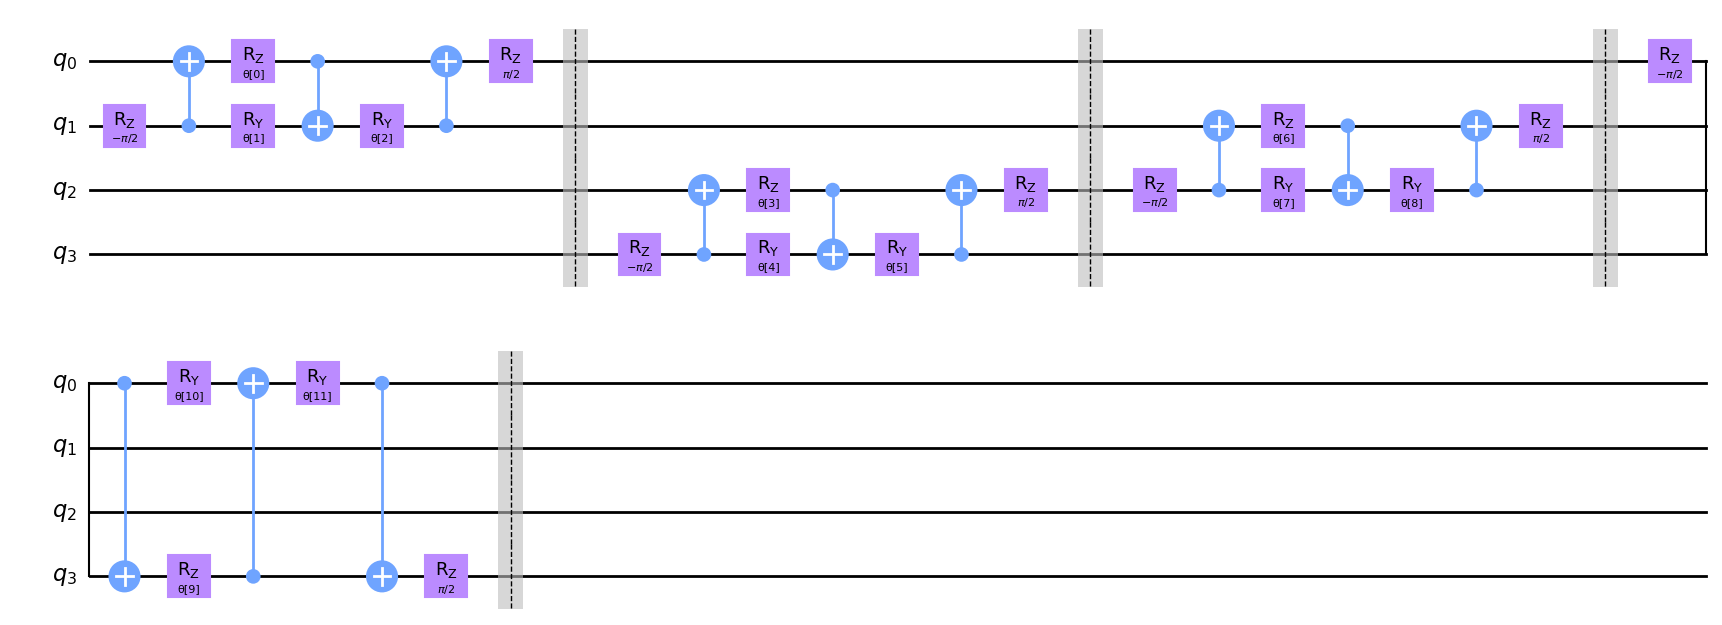

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

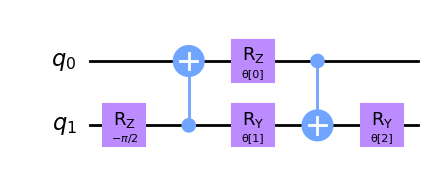

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

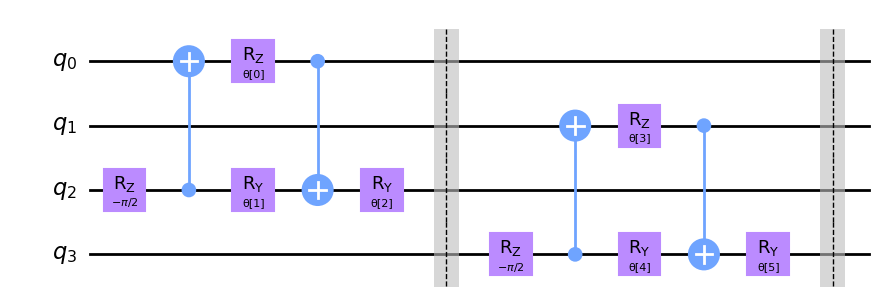

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [ ]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/RESEARCH/QML_ADNI/AD'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/RESEARCH/QML_ADNI/AD


In [ ]:
from glob import glob
#define size to which images are to be resized
IMAGE_SIZE = [128, 128] # feel free to change depending on dataset

# training config:
epochs = 10
batch_size = 32

#define paths
AD_path = 'Mild_Demented'
CT_path = 'Non_Demented'

# Use glob to grab images from path .jpg or jpeg
AD_files = glob(AD_path + '/*')
CT_files = glob(CT_path + '/*')

In [ ]:
def rgb_to_gray(rgb_image):
    # Convert RGB image to grayscale using luminance method
    gray_image = np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

    # Convert to uint8 type
    gray_image = gray_image.astype(np.uint8)

    return gray_image

In [ ]:
from os import ctermid
# Preparing Labels
AD_labels = []
CT_labels = []

AD_images=[]
CT_images=[]

import cv2

for i in range(20):
  image = cv2.imread(AD_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(4,4))
  image = rgb_to_gray(image)
  AD_images.append(image)
  AD_labels.append(1)
for i in range(20):
  image = cv2.imread(CT_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(4,4))
  image = rgb_to_gray(image)
  CT_images.append(image)
  CT_labels.append(-1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
AD_x_train, AD_x_test, AD_y_train, AD_y_test = train_test_split(
    AD_images, AD_labels, test_size=0.2)
CT_x_train, CT_x_test, CT_y_train, CT_y_test = train_test_split(
    CT_images, CT_labels, test_size=0.2)


train_images1 = np.concatenate((CT_x_train, AD_x_train), axis=0)
test_images1 = np.concatenate((CT_x_test, AD_x_test), axis=0)
train_labels = np.concatenate((CT_y_train, AD_y_train), axis=0)
test_labels = np.concatenate((CT_y_test, AD_y_test), axis=0)

# make labels into categories - either 0 or 1
#y_train = LabelBinarizer().fit_transform(y_train)
#y_train = to_categorical(y_train)

#y_test = LabelBinarizer().fit_transform(y_test)
#y_test = to_categorical(y_test)

In [ ]:
train_images = []
test_images = []
for i in range(len(train_images1)):
  train_images.append(train_images1[i].flatten())

for i in range(len(test_images1)):
  test_images.append(test_images1[i].flatten())

In [ ]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

Let's see some examples in our dataset

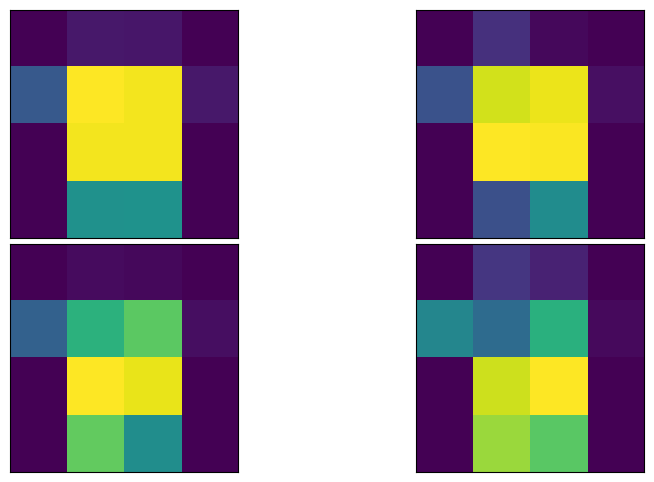

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(4, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

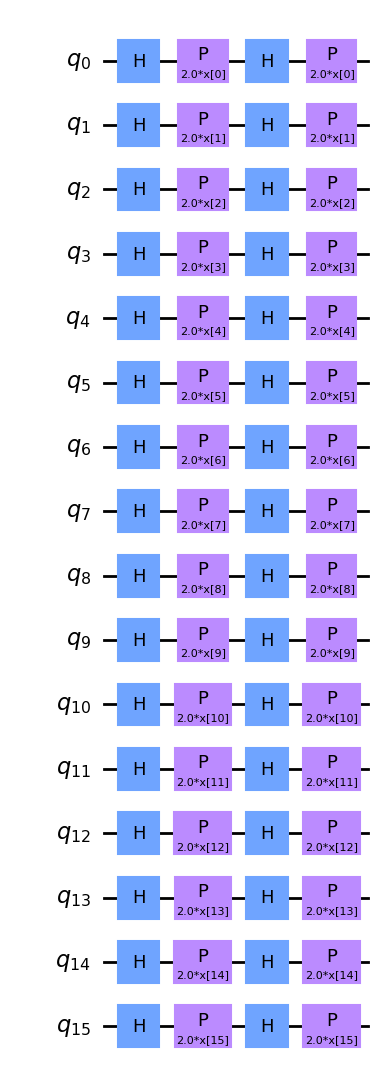

In [ ]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl", style="clifford")

In [ ]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [ ]:
circuit.draw("mpl", style="clifford")

In [ ]:
tot_qbits = 16
feature_map = ZFeatureMap(tot_qbits)

ansatz = QuantumCircuit(tot_qbits, name="Ansatz")

qbits = tot_qbits
cnt_l = 0
cnv = "c"
pll = "p"
cnt = 1
while qbits > 1:
  #print(f"{cnv+str(cnt)} - {qbits} - {list(range(cnt_l, tot_qbits))}")
  ansatz.compose(conv_layer(qbits, cnv+str(cnt)), list(range(cnt_l, tot_qbits)), inplace=True)
  ansatz.compose(pool_layer(list(range(0, int(qbits/2))), list(range(int(qbits/2), qbits)), pll+str(cnt)), list(range(cnt_l, tot_qbits)), inplace=True)
  #print(f"{pll+str(cnt)} - {list(range(0, int(qbits/2)))} - {list(range(int(qbits/2), qbits))} - {list(range(cnt_l, tot_qbits))}")
  cnt_l = cnt_l + int(qbits/2)
  qbits = int(qbits/2)
  cnt = cnt + 1
  #print(f"V - qbits={qbits} - cnt_l={cnt_l} - {cnt}")

# Combining the feature map and ansatz
circuit = QuantumCircuit(tot_qbits)
circuit.compose(feature_map, range(tot_qbits), inplace=True)
circuit.compose(ansatz, range(tot_qbits), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

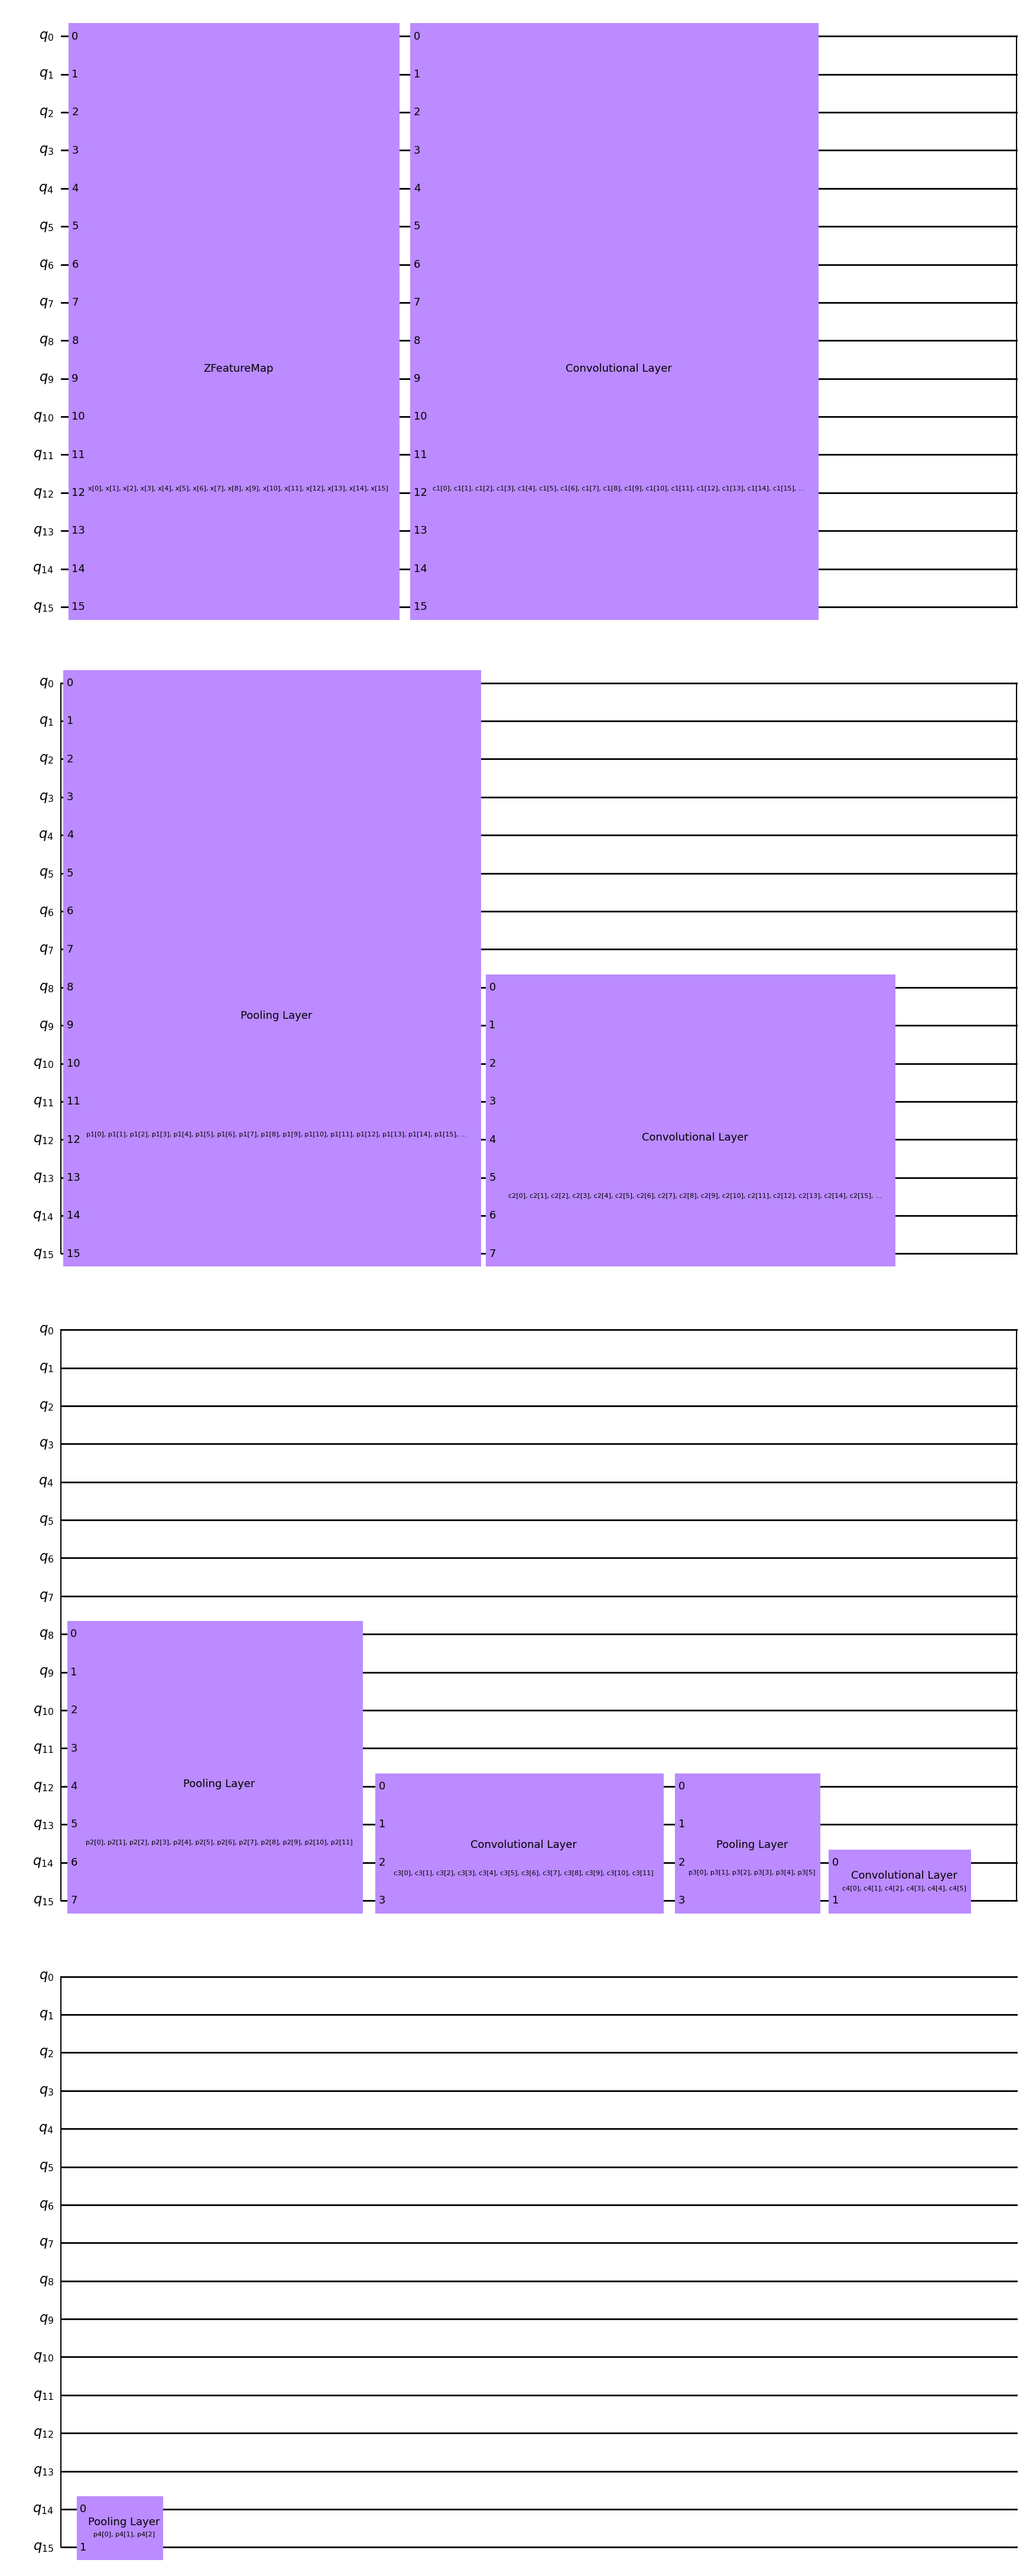

In [ ]:
circuit.draw("mpl", style="clifford")

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)
import random
sample_weight = [random.random() for _ in range(135)]

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=10),  # Set max iterations here
    callback=callback_graph,
    initial_point=sample_weight,
)

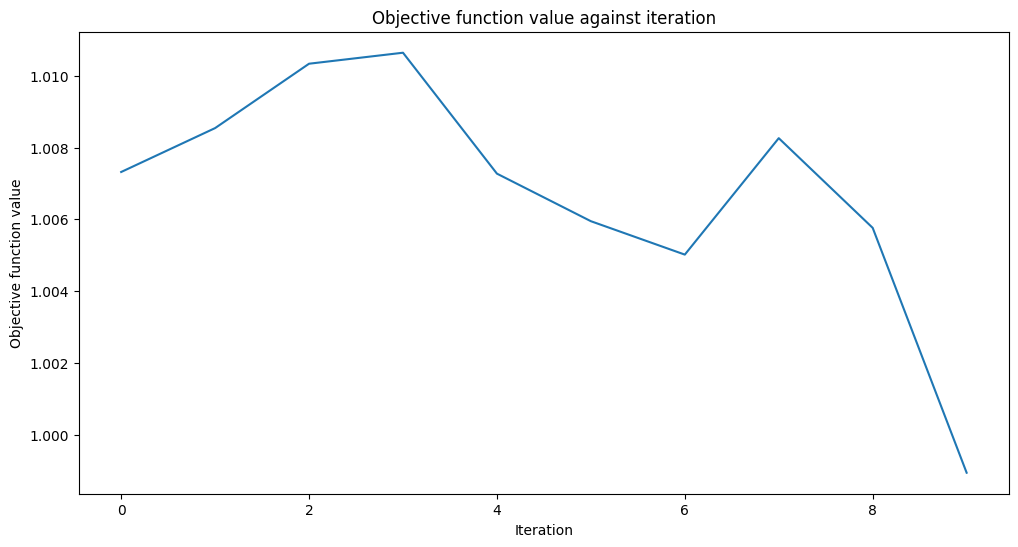

Accuracy from the train data : 46.88%


In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 62.5%


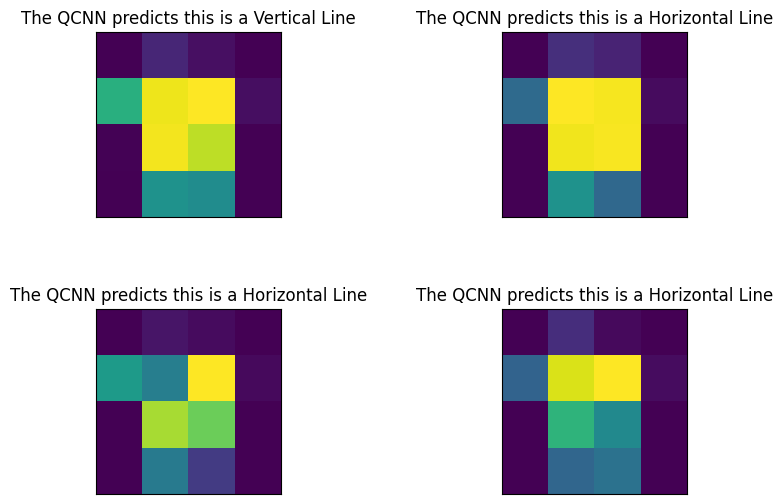

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)